In [ ]:
# GEO query and DEG analysis script
🧬 Gene Expression Omnibus (GEO) Analysis using Python 🐍

Welcome to the GEO Analysis with Python project! 🚀
This repository provides tools, scripts, and workflows to fetch 📥, process 🛠️, and analyze 📊 gene expression data from the NCBI Gene Expression Omnibus (GEO) database.

📺 Stay Connected

👉 For more tutorials and omics-related content, follow Future Omics on YouTube!
🔗 Future Omics YouTube Channel
 Follow like, share, and subscribe https://www.youtube.com/@Bioinformatics_Made_Easy 🎥✨

# Install dependencies if not already installed:
!pip install GEOparse pandas matplotlib seaborn scipy numpy

import GEOparse
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns




In [ ]:
# Step 1: Download GEO dataset
gse_id = "GSE57691"   # <-- Change to any GEO Series ID
gse = GEOparse.get_GEO(geo=gse_id, destdir=".")

print(f"Dataset: {gse_id}")
print(f"Title: {gse.metadata['title'][0]}")
#print(f"Organism: {gse.metadata['organism_ch1'][0]}")
print(f"Samples: {len(gse.gsms)}")



10-Sep-2025 16:50:42 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
10-Sep-2025 16:50:42 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
10-Sep-2025 16:50:42 INFO GEOparse - Parsing ./GSE57691_family.soft.gz: 
INFO:GEOparse:Parsing ./GSE57691_family.soft.gz: 
10-Sep-2025 16:50:42 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
10-Sep-2025 16:50:42 DEBUG GEOparse - SERIES: GSE57691
DEBUG:GEOparse:SERIES: GSE57691
10-Sep-2025 16:50:42 DEBUG GEOparse - PLATFORM: GPL10558
DEBUG:GEOparse:PLATFORM: GPL10558
10-Sep-2025 16:50:44 DEBUG GEOparse - SAMPLE: GSM1386783
DEBUG:GEOparse:SAMPLE: GSM1386783
10-Sep-2025 16:50:44 DEBUG GEOparse - SAMPLE: GSM1386784
DEBUG:GEOparse:SAMPLE: GSM1386784
10-Sep-2025 16:50:44 DEBUG GEOparse - SAMPLE: GSM1386785
DEBUG:GEOparse:SAMPLE: GSM1386785
10-Sep-2025 16:50:44 DEBUG GEOparse - SAMPLE: GSM1386786
DEBUG:GEOparse:SAMP

Dataset: GSE57691
Title: Differential gene expression in human abdominal aortic aneurysm and atherosclerosis
Samples: 68


In [ ]:
# Step 2: Build expression matrix
dfs = []
for gsm_name, gsm in gse.gsms.items():
    if gsm.table is not None and "VALUE" in gsm.table.columns:
        df = gsm.table[["ID_REF", "VALUE"]].copy()
        df.rename(columns={"VALUE": gsm_name}, inplace=True)
        dfs.append(df)

expr_df = dfs[0]
for df in dfs[1:]:
    expr_df = expr_df.merge(df, on="ID_REF")

expr_df.set_index("ID_REF", inplace=True)

print("Expression Matrix Shape:", expr_df.shape)

# Save raw expression matrix
expr_df.to_csv("expression.csv")
print("✅ Saved: expression.csv")



Expression Matrix Shape: (39426, 68)
✅ Saved: expression.csv


In [ ]:
# Step 3: Differential Expression Analysis
n = len(expr_df.columns)
control = expr_df.iloc[:, :n//2]
treated = expr_df.iloc[:, n//2:]

pvals, logFCs = [], []
for gene in expr_df.index:
    stat, p = ttest_ind(control.loc[gene], treated.loc[gene], nan_policy="omit")
    logFC = treated.loc[gene].mean() - control.loc[gene].mean()
    pvals.append(p)
    logFCs.append(logFC)

deg_df = pd.DataFrame({
    "Gene": expr_df.index,
    "logFC": logFCs,
    "pval": pvals
})
deg_df["-log10p"] = -np.log10(deg_df["pval"])

# Save DEG results
deg_df.to_csv("DEG.csv", index=False)
print("✅ Saved: DEG.csv")



✅ Saved: DEG.csv


✅ Saved: significant.csv (42 significant genes)


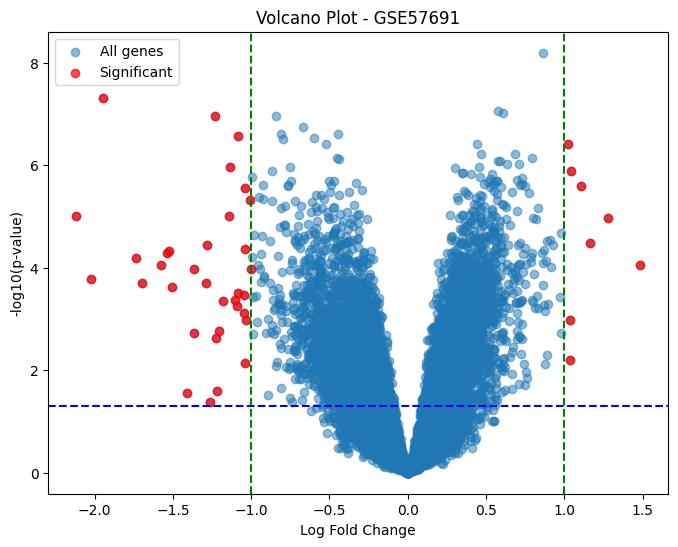

✅ Saved: volcano_plot.png


In [ ]:
# Step 4: Filter significant DEGs
# Thresholds: p < 0.05 and |logFC| > 1
sig_df = deg_df[(deg_df["pval"] < 0.05) & (abs(deg_df["logFC"]) > 1)]

sig_df.to_csv("significant.csv", index=False)
print(f"✅ Saved: significant.csv ({sig_df.shape[0]} significant genes)")

# Step 5: Volcano plot
plt.figure(figsize=(8,6))
plt.scatter(deg_df["logFC"], deg_df["-log10p"], alpha=0.5, label="All genes")
plt.scatter(sig_df["logFC"], sig_df["-log10p"], color="red", alpha=0.7, label="Significant")
plt.axhline(-np.log10(0.05), color="blue", linestyle="--")
plt.axvline(-1, color="green", linestyle="--")
plt.axvline(1, color="green", linestyle="--")
plt.xlabel("Log Fold Change")
plt.ylabel("-log10(p-value)")
plt.title(f"Volcano Plot - {gse_id}")
plt.legend()
plt.savefig("volcano_plot.png", dpi=300)
plt.show()

print("✅ Saved: volcano_plot.png")